# Shooting Pose Classification with XGBoost

This notebook trains an XGBoost classifier to detect shooting poses from human pose keypoints.

**Dataset**: Pose CSV files with labeled shooting_pose annotations  
**Features**: 51 keypoint features (17 keypoints × 3: x, y, confidence)  
**Target**: shooting_pose (0 = non-shooting, 1 = shooting)


## 1. Import Libraries


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")


Libraries imported successfully!
XGBoost version: 3.1.1


## 2. Load Data


In [ ]:
# Data directory
data_dir = Path('posecsv_with_labels')

# Load all CSV files
csv_files = sorted(list(data_dir.glob('*.csv')))
print(f"Found {len(csv_files)} CSV files:")
for csv_file in csv_files:
    print(f"  - {csv_file.name}")

# Load and concatenate all data
all_data = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    print(f"\n{csv_file.name}: {len(df)} rows")
    all_data.append(df)

# Combine all dataframes
df = pd.concat(all_data, ignore_index=True)

print(f"\n{'='*60}")
print(f"Total combined dataset: {len(df)} rows, {len(df.columns)} columns")
print(f"{'='*60}")


Found 7 CSV files:
  - block26_pose_data_20251105_233633.csv
  - block30_pose_data_20251105_234846.csv
  - block31_pose_data_20251105_235516.csv
  - block35_pose_data_20251105_235809.csv
  - block36_pose_data_20251106_000020.csv
  - euth-block25_pose_data_20251106_041245.csv
  - sick-cow-pen-block75_pose_data_20251106_041532.csv

block26_pose_data_20251105_233633.csv: 317 rows

block30_pose_data_20251105_234846.csv: 269 rows

block31_pose_data_20251105_235516.csv: 533 rows

block35_pose_data_20251105_235809.csv: 347 rows

block36_pose_data_20251106_000020.csv: 220 rows

euth-block25_pose_data_20251106_041245.csv: 857 rows

sick-cow-pen-block75_pose_data_20251106_041532.csv: 1345 rows

Total combined dataset: 3888 rows, 61 columns


In [ ]:
# Display sample data
print("Sample of loaded data:")
df.head()


Sample of loaded data:


,frame_number,timestamp_seconds,timestamp_formatted,human_id,bbox_x1,bbox_y1,bbox_x2,bbox_y2,human_conf,nose_x,...,right_knee_x,right_knee_y,right_knee_conf,left_ankle_x,left_ankle_y,left_ankle_conf,right_ankle_x,right_ankle_y,right_ankle_conf,shooting_pose
0,25,1.666667,00:00:01.667,0,738,1,812,86,0.522519,782.362000,...,773.236450,58.120342,0.976482,784.471619,76.460663,0.830448,772.942200,76.119301,0.839465,0
1,26,1.733333,00:00:01.733,0,738,1,811,86,0.514813,780.234009,...,772.740479,58.341595,0.973199,785.614746,77.015259,0.785840,773.064636,76.637825,0.792784,0
2,27,1.800000,00:00:01.800,0,737,1,810,86,0.504261,779.474304,...,772.558533,60.296902,0.967992,785.602112,77.278992,0.737825,773.237915,76.506424,0.757126,0
3,28,1.866667,00:00:01.867,0,736,1,809,86,0.507162,781.728455,...,774.237183,60.027889,0.990652,786.122314,77.654480,0.883774,774.486084,77.844337,0.892123,0
4,32,2.133333,00:00:02.133,0,735,1,808,86,0.500806,778.777039,...,772.851013,59.140213,0.981024,786.415405,76.031509,0.849782,773.887573,75.609367,0.867801,0


In [ ]:
# Check data info
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888 entries, 0 to 3887
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frame_number         3888 non-null   int64  
 1   timestamp_seconds    3888 non-null   float64
 2   timestamp_formatted  3888 non-null   object 
 3   human_id             3888 non-null   int64  
 4   bbox_x1              3888 non-null   int64  
 5   bbox_y1              3888 non-null   int64  
 6   bbox_x2              3888 non-null   int64  
 7   bbox_y2              3888 non-null   int64  
 8   human_conf           3888 non-null   float64
 9   nose_x               3888 non-null   float64
 10  nose_y               3888 non-null   float64
 11  nose_conf            3888 non-null   float64
 12  left_eye_x           3888 non-null   float64
 13  left_eye_y           3888 non-null   float64
 14  left_eye_conf        3888 non-null   float64
 15  right_eye_x          388

## 3. Exploratory Data Analysis


In [ ]:
# Check target variable distribution
print("Shooting Pose Label Distribution:")
print(df['shooting_pose'].value_counts())
print("\nClass Balance (%)")
print(df['shooting_pose'].value_counts(normalize=True) * 100)

# Calculate imbalance ratio
class_counts = df['shooting_pose'].value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Scale Pos Weight for XGBoost: {imbalance_ratio:.2f}")


Shooting Pose Label Distribution:
shooting_pose
0    3689
1     199
Name: count, dtype: int64

Class Balance (%)
shooting_pose
0    94.881687
1     5.118313
Name: proportion, dtype: float64

Imbalance Ratio: 18.54:1
Scale Pos Weight for XGBoost: 18.54


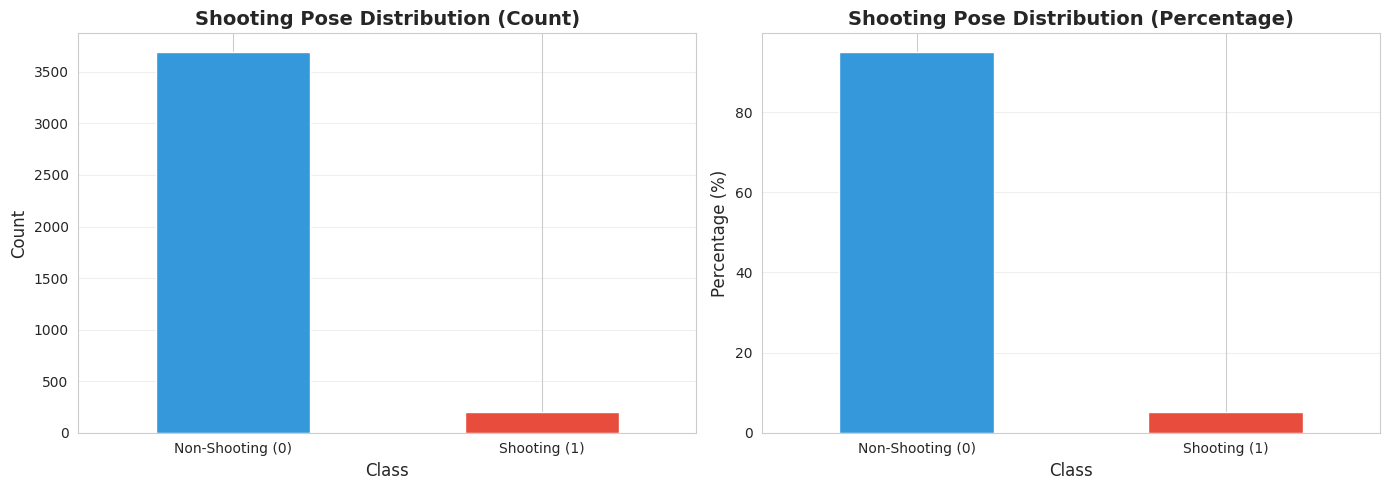


⚠️ Note: Severe class imbalance detected! We'll use scale_pos_weight to handle this.


In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['shooting_pose'].value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Shooting Pose Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Non-Shooting (0)', 'Shooting (1)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
(df['shooting_pose'].value_counts(normalize=True) * 100).plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c'])
axes[1].set_title('Shooting Pose Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_xticklabels(['Non-Shooting (0)', 'Shooting (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Severe class imbalance detected! We'll use scale_pos_weight to handle this.")


In [ ]:
# Check for missing values
print("Missing Values Summary:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})

if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found!")


Missing Values Summary:
✓ No missing values found!


## 4. Feature Selection

We'll use only the **51 keypoint features** (17 keypoints × 3: x, y, confidence) as inputs to the model.


In [ ]:
# Define keypoint names (COCO format)
keypoint_names = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

# Generate keypoint column names
keypoint_columns = []
for kp in keypoint_names:
    keypoint_columns.extend([f'{kp}_x', f'{kp}_y', f'{kp}_conf'])

print(f"Total keypoint features: {len(keypoint_columns)}")
print(f"\nKeypoint columns (first 10):")
for i, col in enumerate(keypoint_columns[:10]):
    print(f"  {i+1}. {col}")
print("  ...")


Total keypoint features: 51

Keypoint columns (first 10):
  1. nose_x
  2. nose_y
  3. nose_conf
  4. left_eye_x
  5. left_eye_y
  6. left_eye_conf
  7. right_eye_x
  8. right_eye_y
  9. right_eye_conf
  10. left_ear_x
  ...


In [ ]:
# Columns to drop (temporal data and metadata)
columns_to_drop = [
    'frame_number', 'timestamp_seconds', 'timestamp_formatted',
    'human_id', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'human_conf'
]

print("Columns being dropped:")
for col in columns_to_drop:
    print(f"  - {col}")

# Verify all keypoint columns exist
missing_cols = [col for col in keypoint_columns if col not in df.columns]
if missing_cols:
    print(f"\n⚠️ Warning: Missing columns: {missing_cols}")
else:
    print("\n✓ All keypoint columns found!")


Columns being dropped:
  - frame_number
  - timestamp_seconds
  - timestamp_formatted
  - human_id
  - bbox_x1
  - bbox_y1
  - bbox_x2
  - bbox_y2
  - human_conf

✓ All keypoint columns found!


In [ ]:
# Separate features and target
X = df[keypoint_columns].copy()
y = df['shooting_pose'].copy()

print(f"Feature matrix X: {X.shape}")
print(f"Target vector y: {y.shape}")
print(f"\nFeature names: {X.columns.tolist()[:5]} ... (showing first 5)")


Feature matrix X: (3888, 51)
Target vector y: (3888,)

Feature names: ['nose_x', 'nose_y', 'nose_conf', 'left_eye_x', 'left_eye_y'] ... (showing first 5)


## 5. Data Preprocessing


In [ ]:
# Check for any remaining missing values in features
print("Missing values in feature matrix:")
missing_features = X.isnull().sum()
if missing_features.sum() > 0:
    print(missing_features[missing_features > 0])
    print("\nHandling missing values by filling with 0...")
    X = X.fillna(0)
    print("✓ Missing values handled!")
else:
    print("✓ No missing values in features!")

# Check for any infinite values
inf_count = np.isinf(X).sum().sum()
if inf_count > 0:
    print(f"\n⚠️ Found {inf_count} infinite values. Replacing with 0...")
    X = X.replace([np.inf, -np.inf], 0)
    print("✓ Infinite values handled!")
else:
    print("✓ No infinite values found!")


Missing values in feature matrix:
✓ No missing values in features!
✓ No infinite values found!


In [ ]:
# Basic statistics of features
print("Feature Statistics:")
X.describe()


Feature Statistics:


,nose_x,nose_y,nose_conf,left_eye_x,left_eye_y,left_eye_conf,right_eye_x,right_eye_y,right_eye_conf,left_ear_x,...,left_knee_conf,right_knee_x,right_knee_y,right_knee_conf,left_ankle_x,left_ankle_y,left_ankle_conf,right_ankle_x,right_ankle_y,right_ankle_conf
count,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,...,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000,3888.000000
mean,939.037573,292.661316,0.581870,940.096293,289.191150,0.504659,938.550087,289.301245,0.436220,941.539139,...,0.959264,936.457629,393.427827,0.960811,935.859333,430.485401,0.897408,934.577110,429.612878,0.890535
std,139.738359,157.961078,0.393123,139.329074,157.544697,0.413187,140.390011,157.469787,0.404798,139.243608,...,0.156837,139.667427,164.643239,0.145385,134.708128,167.597682,0.202203,137.888719,167.326019,0.199632
min,374.817963,0.000000,0.001366,375.593292,0.000000,0.000404,369.817383,0.000000,0.000285,368.390900,...,0.003045,364.577087,42.971848,0.003683,372.049561,43.515926,0.001331,367.842102,44.942390,0.001286
25%,879.064392,190.873878,0.135809,881.780075,187.702396,0.059775,877.340256,187.523029,0.018805,887.400818,...,0.991265,880.894852,281.933640,0.987729,888.025757,318.031677,0.921677,883.028900,316.811531,0.903262
50%,938.993469,244.109406,0.713242,938.319214,239.600021,0.513801,941.105225,240.205750,0.303559,936.770935,...,0.996616,932.386780,352.968323,0.995799,923.037994,389.827637,0.967235,928.535095,388.314407,0.962797
75%,1029.927612,379.770439,0.976732,1033.669952,377.635735,0.957312,1028.160156,377.455116,0.904544,1037.942108,...,0.998476,1021.895050,460.363556,0.998341,1024.963745,489.333267,0.984284,1021.499832,489.119980,0.984352
max,1284.789673,1080.000000,0.998199,1285.808350,1079.041748,0.998070,1283.276978,1078.382080,0.997822,1284.930542,...,0.999831,1261.022095,1078.201050,0.999809,1264.223267,1080.000000,0.998461,1256.017456,1080.000000,0.998342


## 6. Train-Test Split


In [ ]:
# Stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dataset Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())


Dataset Split:
  Training set: 3110 samples
  Test set: 778 samples

Training set class distribution:
shooting_pose
0    2951
1     159
Name: count, dtype: int64

Test set class distribution:
shooting_pose
0    738
1     40
Name: count, dtype: int64


## 7. XGBoost Model Training

We'll use `scale_pos_weight` to handle class imbalance.


In [ ]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

print("\nXGBoost Model Initialized!")
print("\nModel Parameters:")
print(xgb_model.get_params())


Scale Pos Weight: 18.56

XGBoost Model Initialized!

Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': np.float64(18.559748427672957), 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verb

In [ ]:
# Train the model
print("Training XGBoost model...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("\n✓ Model training complete!")


Training XGBoost model...

✓ Model training complete!


## 8. Model Evaluation


In [ ]:
# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Prediction probabilities for ROC curve
y_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Predictions generated!")


Predictions generated!


In [ ]:
# Training set metrics
print("="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")


TRAINING SET PERFORMANCE
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

TEST SET PERFORMANCE
Accuracy: 0.9743
Precision: 0.7273
Recall: 0.8000
F1-Score: 0.7619
ROC-AUC: 0.9855


In [ ]:
# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Non-Shooting', 'Shooting']))



Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

Non-Shooting       0.99      0.98      0.99       738
    Shooting       0.73      0.80      0.76        40

    accuracy                           0.97       778
   macro avg       0.86      0.89      0.87       778
weighted avg       0.98      0.97      0.97       778



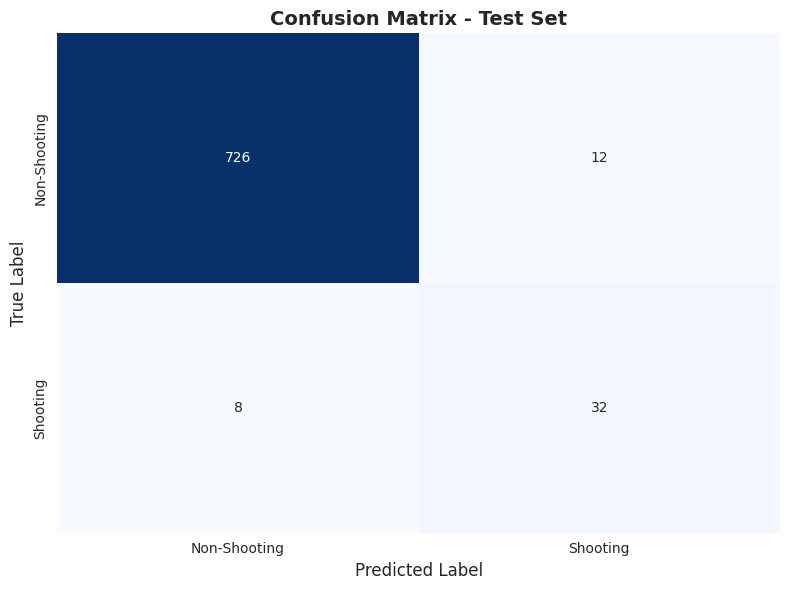


Confusion Matrix Breakdown:
  True Negatives (TN): 726
  False Positives (FP): 12
  False Negatives (FN): 8
  True Positives (TP): 32


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
            xticklabels=['Non-Shooting', 'Shooting'],
            yticklabels=['Non-Shooting', 'Shooting'])
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP): {tp}")


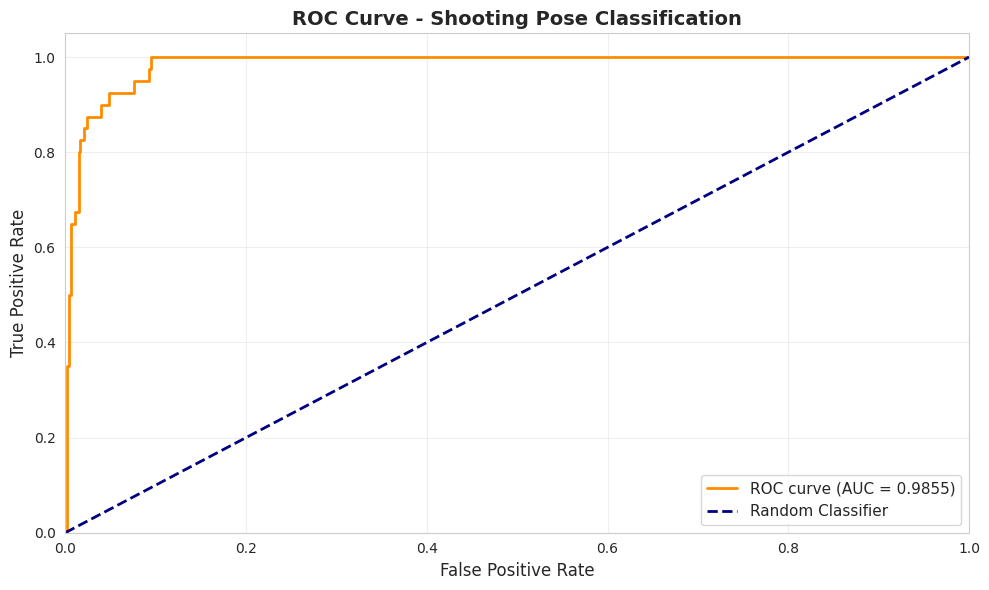

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Shooting Pose Classification', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Feature Importance Analysis


In [ ]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))


Top 20 Most Important Features:
               Feature  Importance
17  left_shoulder_conf    0.124372
7          right_eye_y    0.093905
24       right_elbow_x    0.077013
13         right_ear_y    0.033351
47     left_ankle_conf    0.033300
31       right_wrist_y    0.032071
36         right_hip_x    0.031861
21        left_elbow_x    0.028270
16     left_shoulder_y    0.028027
27        left_wrist_x    0.027039
42        right_knee_x    0.027012
15     left_shoulder_x    0.023556
44     right_knee_conf    0.023215
37         right_hip_y    0.022465
46        left_ankle_y    0.022156
18    right_shoulder_x    0.021546
10          left_ear_y    0.021019
45        left_ankle_x    0.020829
48       right_ankle_x    0.019863
12         right_ear_x    0.018631


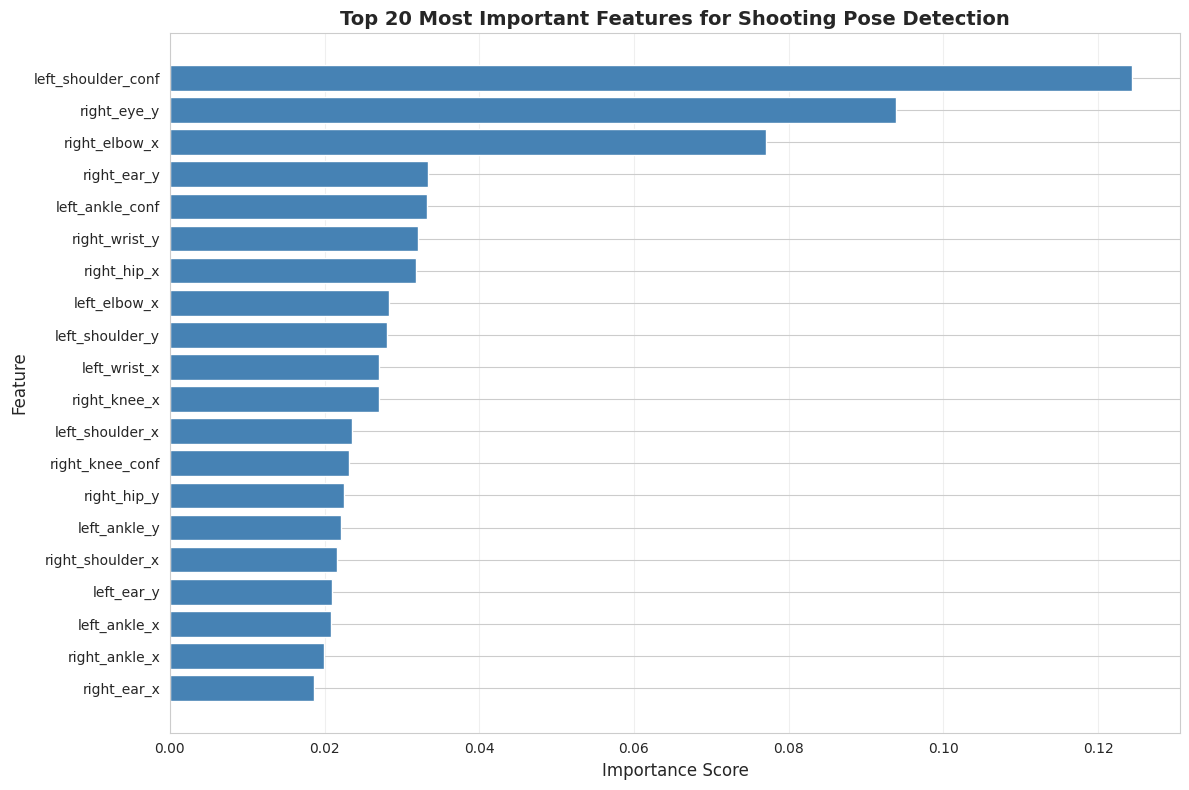

In [ ]:
# Plot top 20 feature importances
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Most Important Features for Shooting Pose Detection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Analyze importance by keypoint (aggregate x, y, conf)
keypoint_importance = {}
for kp in keypoint_names:
    kp_features = [f'{kp}_x', f'{kp}_y', f'{kp}_conf']
    kp_importance = feature_importance[feature_importance['Feature'].isin(kp_features)]['Importance'].sum()
    keypoint_importance[kp] = kp_importance

# Convert to dataframe and sort
kp_importance_df = pd.DataFrame({
    'Keypoint': list(keypoint_importance.keys()),
    'Total Importance': list(keypoint_importance.values())
}).sort_values('Total Importance', ascending=False)

print("\nKeypoint Importance Ranking (aggregated x, y, conf):")
print(kp_importance_df)



Keypoint Importance Ranking (aggregated x, y, conf):
          Keypoint  Total Importance
5    left_shoulder          0.175955
2        right_eye          0.107790
8      right_elbow          0.099134
15      left_ankle          0.076286
4        right_ear          0.067313
12       right_hip          0.065134
14      right_knee          0.052600
10     right_wrist          0.049220
7       left_elbow          0.048225
16     right_ankle          0.039731
3         left_ear          0.035973
9       left_wrist          0.035735
11        left_hip          0.031568
13       left_knee          0.030887
6   right_shoulder          0.030307
1         left_eye          0.027841
0             nose          0.026299


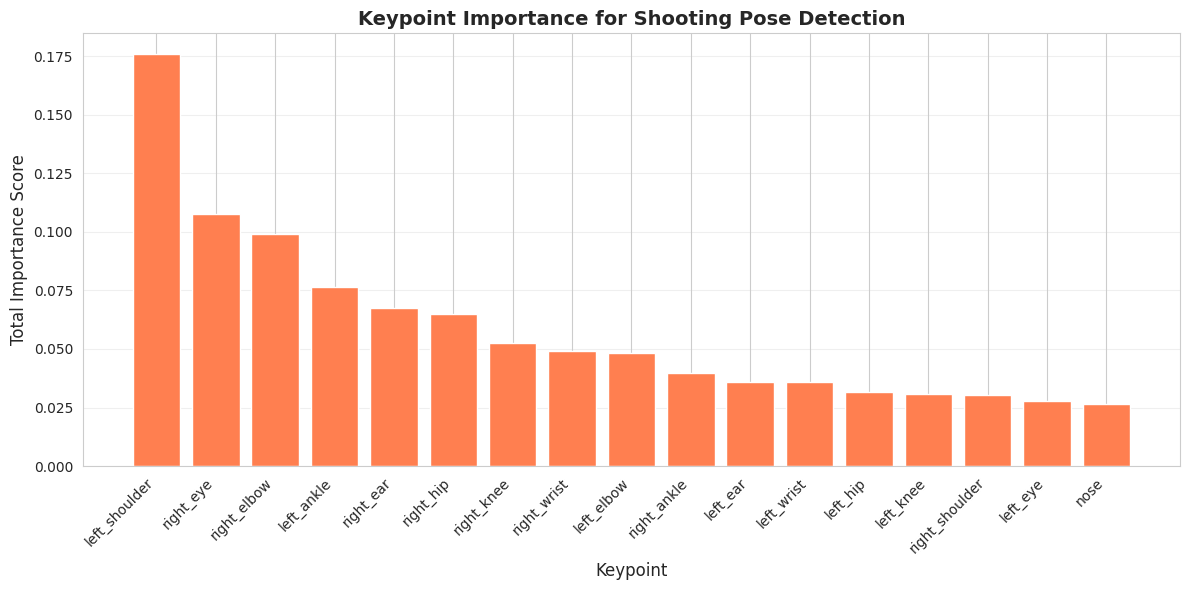

In [ ]:
# Plot keypoint importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(kp_importance_df)), kp_importance_df['Total Importance'], color='coral')
plt.xticks(range(len(kp_importance_df)), kp_importance_df['Keypoint'], rotation=45, ha='right')
plt.xlabel('Keypoint', fontsize=12)
plt.ylabel('Total Importance Score', fontsize=12)
plt.title('Keypoint Importance for Shooting Pose Detection', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Perform stratified k-fold cross-validation
print("Performing 5-fold cross-validation...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate multiple metrics
cv_scores = {
    'accuracy': cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy'),
    'precision': cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='precision'),
    'recall': cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='recall'),
    'f1': cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1'),
    'roc_auc': cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc')
}

print("\nCross-Validation Results (5-fold):")
print("="*60)
for metric, scores in cv_scores.items():
    print(f"{metric.upper():12s}: {scores.mean():.4f} (+/- {scores.std():.4f})")
print("="*60)


Performing 5-fold cross-validation...


KeyboardInterrupt: 

## 11. Save Model


In [ ]:
import pickle
import json

# Save the trained model in multiple formats

# 1. Save as XGBoost native JSON format (recommended for XGBoost)
model_path_json = 'shooting_pose_xgboost_model.json'
xgb_model.save_model(model_path_json)
print(f"✓ Model saved (JSON format): {model_path_json}")

# 2. Save as pickle format (for scikit-learn compatibility)
model_path_pkl = 'shooting_pose_xgboost_model.pkl'
with open(model_path_pkl, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✓ Model saved (Pickle format): {model_path_pkl}")

# 3. Save feature names for future reference
feature_names_path = 'feature_names.txt'
with open(feature_names_path, 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")
print(f"✓ Feature names saved to: {feature_names_path}")

# 4. Save model metadata
metadata = {
    'model_type': 'XGBClassifier',
    'n_features': X.shape[1],
    'feature_names': X.columns.tolist(),
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'class_imbalance_ratio': float(imbalance_ratio),
    'scale_pos_weight': float(scale_pos_weight),
    'test_accuracy': float(accuracy_score(y_test, y_test_pred)),
    'test_precision': float(precision_score(y_test, y_test_pred)),
    'test_recall': float(recall_score(y_test, y_test_pred)),
    'test_f1': float(f1_score(y_test, y_test_pred)),
    'test_roc_auc': float(roc_auc_score(y_test, y_test_pred_proba)),
    'model_params': xgb_model.get_params()
}

metadata_path = 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Model metadata saved to: {metadata_path}")

print("\n" + "="*60)
print("All files saved successfully!")
print("="*60)
print(f"  1. {model_path_json} - XGBoost model (JSON)")
print(f"  2. {model_path_pkl} - XGBoost model (Pickle)")
print(f"  3. {feature_names_path} - Feature names")
print(f"  4. {metadata_path} - Model metadata")
print("="*60)


✓ Model saved (JSON format): shooting_pose_xgboost_model.json
✓ Model saved (Pickle format): shooting_pose_xgboost_model.pkl
✓ Feature names saved to: feature_names.txt
✓ Model metadata saved to: model_metadata.json

All files saved successfully!
  1. shooting_pose_xgboost_model.json - XGBoost model (JSON)
  2. shooting_pose_xgboost_model.pkl - XGBoost model (Pickle)
  3. feature_names.txt - Feature names
  4. model_metadata.json - Model metadata


### How to Load the Model Later

Here's how to load and use the saved model for predictions:


In [ ]:
# Example: How to load and use the model for predictions

# Method 1: Load from JSON (recommended for XGBoost)
loaded_model_json = xgb.XGBClassifier()
loaded_model_json.load_model('shooting_pose_xgboost_model.json')
print("✓ Model loaded from JSON")

# Method 2: Load from Pickle
with open('shooting_pose_xgboost_model.pkl', 'rb') as f:
    loaded_model_pkl = pickle.load(f)
print("✓ Model loaded from Pickle")

# Test prediction with a sample from test set
sample_idx = 0
sample_features = X_test.iloc[sample_idx:sample_idx+1]
sample_true_label = y_test.iloc[sample_idx]

# Make prediction
prediction = loaded_model_json.predict(sample_features)[0]
prediction_proba = loaded_model_json.predict_proba(sample_features)[0]

print(f"\n{'='*60}")
print("Sample Prediction Test:")
print(f"{'='*60}")
print(f"True label: {sample_true_label} ({'Shooting' if sample_true_label == 1 else 'Non-Shooting'})")
print(f"Predicted label: {prediction} ({'Shooting' if prediction == 1 else 'Non-Shooting'})")
print(f"Prediction probability:")
print(f"  Non-Shooting: {prediction_proba[0]:.4f}")
print(f"  Shooting: {prediction_proba[1]:.4f}")
print(f"{'='*60}")


## 12. Summary & Insights


In [ ]:
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)
print(f"Total Samples: {len(df)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {X.shape[1]}")
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"\nTop 3 Most Important Keypoints:")
for i, row in kp_importance_df.head(3).iterrows():
    print(f"  {row['Keypoint']}: {row['Total Importance']:.4f}")
print("="*60)
